In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import meshgrid
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torch.autograd import gradcheck
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import shift
from math import sqrt
from scipy.sparse import diags
from scipy.linalg import cholesky

## Load WILDFIRE 1D data

In [21]:
Q_wf = np.load('Wildlandfire_1d_big/SnapShotMatrix558.49.npy', allow_pickle=True)
t = np.load('Wildlandfire_1d_big/Time.npy', allow_pickle=True)
x_grid = np.load('Wildlandfire_1d_big/1D_Grid.npy', allow_pickle=True)
x = x_grid[0]
T = Q_wf[:len(x), :]
seed = 420
torch.manual_seed(seed)

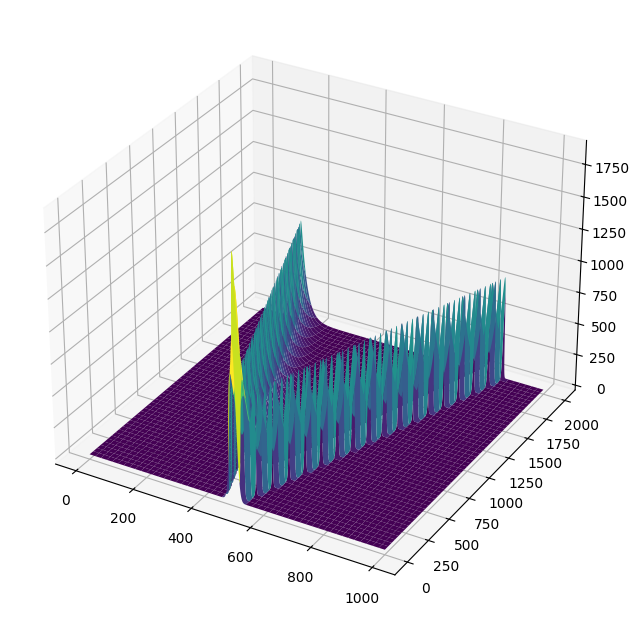

In [22]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower

from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.pyplot as plt
X_1D_grid, t_grid = np.meshgrid(x, t)
X_1D_grid = X_1D_grid.T
t_grid = t_grid.T

ax = plt.axes(projection='3d')
ax.plot_surface(X_1D_grid, t_grid, T, cmap='viridis')
plt.show()

In [23]:
coefficients1 = [-4, 2]
coefficients2 = [0, 0]
coefficients3 = [2, -1]
shifted_t_values1 = np.polyval(coefficients1,t)
shifted_t_values2 = np.polyval(coefficients2,t)
shifted_t_values3 = np.polyval(coefficients3,t)

In [24]:
Q = torch.tensor(T/T.max())
 
X = x
T = t

Nx = len(X)
Nt = len(T)

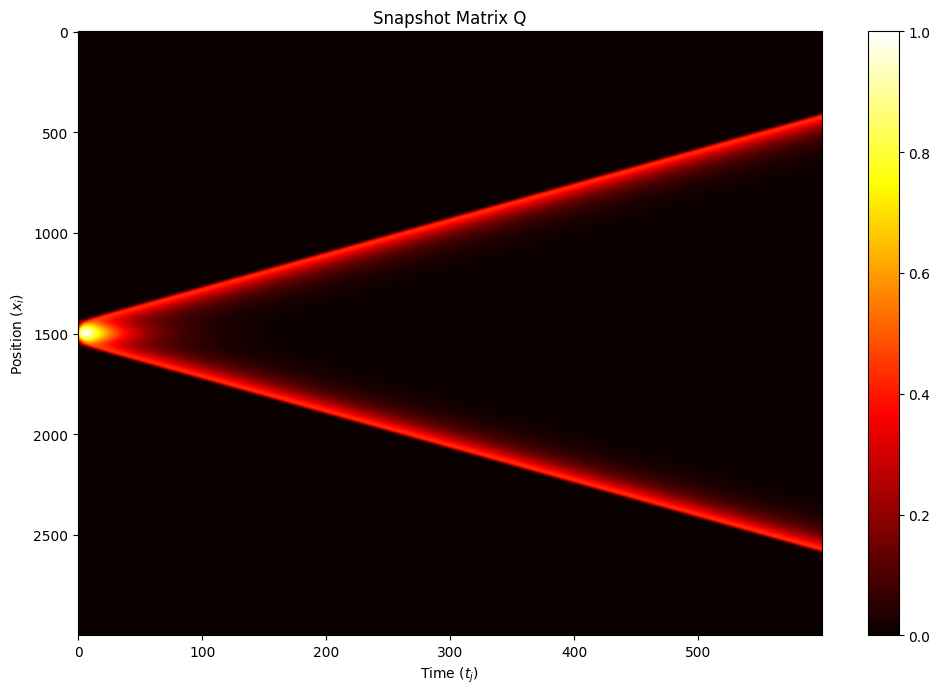

In [25]:
plt.imshow(Q, cmap='hot', aspect='auto')
plt.colorbar()
plt.xlabel('Time ($t_j$)')
plt.ylabel('Position ($x_i$)')
plt.title('Snapshot Matrix Q')
plt.show()

## Define inputs

In [26]:
inputs = np.stack([x.repeat(Nt), np.tile(t, Nx)], axis=1)
targets = Q.flatten()

inputs_tensor = torch.tensor(inputs, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)

dataset = TensorDataset(inputs_tensor, targets_tensor)
data_loader = DataLoader(dataset, batch_size=50, shuffle=True)


/tmp/ipykernel_37452/3066838592.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  targets_tensor = torch.tensor(targets, dtype=torch.float32)


In [27]:
if torch.cuda.is_available():
    print("CUDA is available. Training on GPU...")
    device = torch.device("cuda")
else:
    print("CUDA is not available. Training on CPU...")
    device = torch.device("cpu")

CUDA is not available. Training on CPU...


# Define a model

In [28]:
class NuclearNormAutograd(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input_matrix):
        ctx.save_for_backward(input_matrix)
        return torch.linalg.matrix_norm(input_matrix, ord="nuc")

    @staticmethod
    def backward(ctx, grad_output):
        input_matrix, = ctx.saved_tensors
        u, s, v = torch.svd(input_matrix, some=False)
        rank = torch.sum(s > 0).item()
        dtype = input_matrix.dtype
        eye_approx = torch.diag((s > 0).to(dtype)[:rank])
        grad_input = torch.matmul(torch.matmul(u[:, :rank], eye_approx), v[:, :rank].t())
        return grad_input * grad_output.unsqueeze(-1).unsqueeze(-1)

In [29]:
class ShapeShiftNet(nn.Module):
    def __init__(self, p_init_coeffs1, p_init_coeffs2, p_init_coeffs3):
        super(ShapeShiftNet, self).__init__()
        
        self.alphas1 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs1[::-1]]
        )
        self.alphas2 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs2[::-1]]
        )
        self.alphas3 = nn.ParameterList(
            [nn.Parameter(torch.tensor([coeff], dtype=torch.float32), requires_grad=True) for coeff in p_init_coeffs3[::-1]]
        )        
        
        self.elu = nn.ELU()
        
        # Subnetwork for f^1 and shift^1
        self.f1_fc1 = nn.Linear(2, 5)
        self.f1_fc2 = nn.Linear(5, 10)
        self.f1_fc3 = nn.Linear(10, 5)
        self.f1_fc4 = nn.Linear(5, 1)
        
        self.shift1_fc1 = nn.Linear(1, 5)
        self.shift1_fc2 = nn.Linear(5, 5)
        self.shift1_fc3 = nn.Linear(5, 1)

        
        # Subnetwork for f^2 and shift^2
        self.f2_fc1 = nn.Linear(2, 5)
        self.f2_fc2 = nn.Linear(5, 10)
        self.f2_fc3 = nn.Linear(10, 5)
        self.f2_fc4 = nn.Linear(5, 1)
        
        self.shift2_fc1 = nn.Linear(1, 5)
        self.shift2_fc2 = nn.Linear(5, 5)
        self.shift2_fc3 = nn.Linear(5, 1)
        
        
        # Subnetwork for f^3 and shift^3
        self.f3_fc1 = nn.Linear(2, 5)
        self.f3_fc2 = nn.Linear(5, 10)
        self.f3_fc3 = nn.Linear(10, 5)
        self.f3_fc4 = nn.Linear(5, 1)
        
        self.shift3_fc1 = nn.Linear(1, 5)
        self.shift3_fc2 = nn.Linear(5, 5)
        self.shift3_fc3 = nn.Linear(5, 1)
        
        
    def forward(self, x, t):
        # Pathway for f^1 and shift^1
        shift1 = self.elu(self.shift1_fc1(t))
        shift1 = self.elu(self.shift1_fc2(shift1))
        shift1 = self.shift1_fc3(shift1)
        #shift1 = sum([coeff * t**i for i, coeff in enumerate(self.alphas1)])
        
        x_shifted1 = x + shift1
        f1 = self.elu(self.f1_fc1(torch.cat((x_shifted1, t), dim=1)))
        f1 = self.elu(self.f1_fc2(f1))
        f1 = self.elu(self.f1_fc3(f1))
        f1 = self.f1_fc4(f1)
        
        f1_without_shift = self.elu(self.f1_fc1(torch.cat((x, t), dim=1)))
        f1_without_shift = self.elu(self.f1_fc2(f1_without_shift))
        f1_without_shift = self.elu(self.f1_fc3(f1_without_shift))
        f1_without_shift = self.f1_fc4(f1_without_shift)
        
        
        # Pathway for f^2 and shift^2
        shift2 = self.elu(self.shift2_fc1(t))
        shift2 = self.elu(self.shift2_fc2(shift2))
        shift2 = self.shift2_fc3(shift2)
        #shift2 = sum([coeff * t**i for i, coeff in enumerate(self.alphas2)])
        
        x_shifted2 = x + shift2
        f2 = self.elu(self.f2_fc1(torch.cat((x_shifted2, t), dim=1)))
        f2 = self.elu(self.f2_fc2(f2))
        f2 = self.elu(self.f2_fc3(f2))
        f2 = self.f2_fc4(f2)
        
        f2_without_shift = self.elu(self.f2_fc1(torch.cat((x, t), dim=1)))
        f2_without_shift = self.elu(self.f2_fc2(f2_without_shift))
        f2_without_shift = self.elu(self.f2_fc3(f2_without_shift))
        f2_without_shift = self.f2_fc4(f2_without_shift)
        
        
        # Pathway for f^3 and shift^3      
        shift3 = self.elu(self.shift3_fc1(t))
        shift3 = self.elu(self.shift3_fc2(shift3))
        shift3 = self.shift3_fc3(shift3)
        #shift3 = sum([coeff * t**i for i, coeff in enumerate(self.alphas3)])
        
        x_shifted3 = x + shift3
        f3 = self.elu(self.f3_fc1(torch.cat((x_shifted3, t), dim=1)))
        f3 = self.elu(self.f3_fc2(f3))
        f3 = self.elu(self.f3_fc3(f3))
        f3 = self.f3_fc4(f3)
        
        
        f3_without_shift = self.elu(self.f3_fc1(torch.cat((x, t), dim=1)))
        f3_without_shift = self.elu(self.f3_fc2(f3_without_shift))
        f3_without_shift = self.elu(self.f3_fc3(f3_without_shift))
        f3_without_shift = self.f3_fc4(f3_without_shift)
        
        return f1, f2, f3, f1_without_shift, f2_without_shift, f3_without_shift


In [30]:
init_coefficients1 = [-1,1]
init_coefficients2 = [1,1]
init_coefficients3 = [0,0]

In [31]:
model = ShapeShiftNet(init_coefficients1, init_coefficients2, init_coefficients3)

pretrained_load = True
if pretrained_load:
    state_dict_original = torch.load('model_wildlandfire_1d_small.pth')
    state_dict_new = model.state_dict()
    
    for name, param in state_dict_original.items():
        if name in state_dict_new:
            state_dict_new[name].copy_(param)
            
model.load_state_dict(state_dict_new, strict=False)
    
    
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [32]:
num_epochs = 100_000
lambda_k = 0.1

for epoch in range(num_epochs + 1):
    x, t = inputs_tensor[:, 0:1], inputs_tensor[:, 1:2]
    
    optimizer.zero_grad()
    f1_full, f2_full, f3_full, f1_full_nos, f2_full_nos, f3_full_nos = model(x,t)
    
    frobenius_loss = torch.norm(Q- f1_full.view(Nx, Nt) - f2_full.view(Nx, Nt) - f3_full.view(Nx, Nt),  'fro') ** 2
    
    nuclear_loss_q1 = NuclearNormAutograd.apply(f1_full_nos.view(Nx, Nt)) 
    nuclear_loss_q2 = NuclearNormAutograd.apply(f2_full_nos.view(Nx, Nt))
    nuclear_loss_q3 = NuclearNormAutograd.apply(f3_full_nos.view(Nx, Nt))
    nuclear_loss = lambda_k*(nuclear_loss_q1 + nuclear_loss_q2+ nuclear_loss_q3)
    
    total_loss = nuclear_loss + frobenius_loss
    
    total_loss.backward(retain_graph=True)
    optimizer.step()
    
    #if epoch % 100 == 0:
    print(
            f'Epoch {epoch}/{num_epochs}, Frob Loss: {frobenius_loss.item()}, Nuclear Loss: {nuclear_loss.item()}, Total loss: {total_loss.item()},')

Epoch 0/100000, Frob Loss: 17585.86500716249, Nuclear Loss: 24.74809455871582, Total loss: 17610.613101721206,
Epoch 1/100000, Frob Loss: 32701.50638065534, Nuclear Loss: 71.59845733642578, Total loss: 32773.10483799176,
Epoch 2/100000, Frob Loss: 14529.095743847925, Nuclear Loss: 32.97780227661133, Total loss: 14562.073546124537,
Epoch 3/100000, Frob Loss: 16218.46310315769, Nuclear Loss: 32.20089340209961, Total loss: 16250.66399655979,
Epoch 4/100000, Frob Loss: 21392.633120553775, Nuclear Loss: 43.29706573486328, Total loss: 21435.93018628864,
Epoch 5/100000, Frob Loss: 17712.854278748717, Nuclear Loss: 37.024898529052734, Total loss: 17749.87917727777,
Epoch 6/100000, Frob Loss: 12805.996901575829, Nuclear Loss: 24.553861618041992, Total loss: 12830.55076319387,
Epoch 7/100000, Frob Loss: 12557.379396989234, Nuclear Loss: 19.88027000427246, Total loss: 12577.259666993506,
Epoch 8/100000, Frob Loss: 15216.45217494655, Nuclear Loss: 28.475204467773438, Total loss: 15244.927379414323


KeyboardInterrupt



In [33]:
combined = f1_full + f2_full + f3_full
Q_tilde = combined.view(Nx, Nt).detach().numpy()

[]

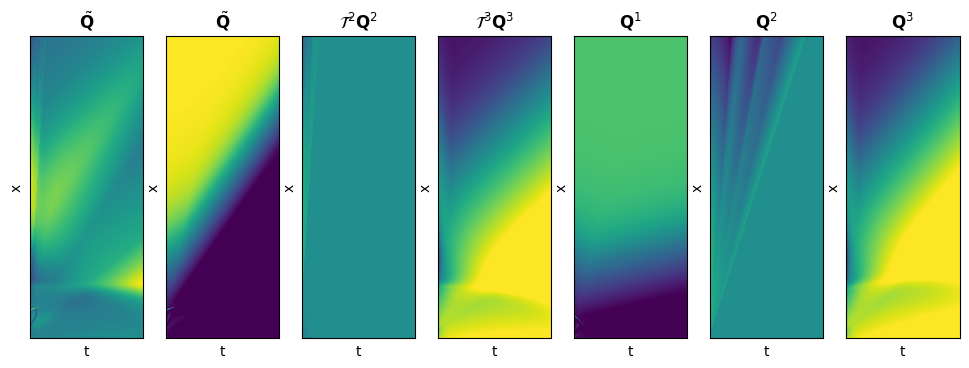

In [34]:
# lambda_k = 0.1
# shift with layers
# f3 with shift


fig, axs = plt.subplots(1, 7, figsize=(12, 4))
vmin = np.min(Q_tilde)
vmax = np.max(Q_tilde)

#Qtilde
axs[0].pcolor(Q_tilde, vmin=vmin, vmax=vmax)
axs[0].set_title(r"$\tilde{\mathbf{Q}}$")
axs[0].set_xlabel("t")
axs[0].set_ylabel("x")
axs[0].set_xticks([])
axs[0].set_yticks([])

# f^1
axs[1].pcolor(f1_full.view(Nx, Nt).detach().numpy(), vmin=vmin)
axs[1].set_title(r"$\mathcal{T}^1\mathbf{Q}^1$")
axs[1].set_title(r"$\tilde{\mathbf{Q}}$")
axs[1].set_xlabel("t")
axs[1].set_ylabel("x")
axs[1].set_xticks([])
axs[1].set_yticks([])

# f^2
axs[2].pcolor(f3_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[2].set_title(r"$\mathcal{T}^2\mathbf{Q}^2$")
axs[2].set_xlabel("t")
axs[2].set_ylabel("x")
axs[2].set_xticks([])
axs[2].set_yticks([])

axs[3].pcolor(f2_full.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[3].set_title(r"$\mathcal{T}^3\mathbf{Q}^3$")
axs[3].set_xlabel("t")
axs[3].set_ylabel("x")
axs[3].set_xticks([])
axs[3].set_yticks([])

# f^1
axs[4].pcolor(f1_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[4].set_title(r"$\mathbf{Q}^1$")
axs[4].set_xlabel("t")
axs[4].set_ylabel("x")
axs[4].set_xticks([])
axs[4].set_yticks([])

# f^2
axs[5].pcolor(f3_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[5].set_title(r"$\mathbf{Q}^2$")
axs[5].set_xlabel("t")
axs[5].set_ylabel("x")
axs[5].set_xticks([])
axs[5].set_yticks([])

axs[6].pcolor(f2_full_nos.view(Nx,Nt).detach().numpy(), vmin=vmin, vmax=vmax)
axs[6].set_title(r"$\mathbf{Q}^3$")
axs[6].set_xlabel("t")
axs[6].set_ylabel("x")
axs[6].set_xticks([])
axs[6].set_yticks([])


In [16]:
#torch.save(model.state_dict(), 'model_wildlandfire_1d_small.pth')